In [6]:
import matplotlib
import matplotlib.pyplot as plt

import os
from pathlib import Path
import random
import io
import imageio
import glob
import scipy.misc
from scipy import io as spio
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [7]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
        path: a file path.

    Returns:
        uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
        image_np: uint8 numpy array with shape (img_height, img_width, 3)
        boxes: a numpy array of shape [N, 4]
        classes: a numpy array of shape [N]. Note that class indices are 1-based,
            and match the keys in the label map.
        scores: a numpy array of shape [N] or None.  If scores=None, then
            this function assumes that the boxes to be plotted are groundtruth
            boxes and plot all boxes as black with no classes or scores.
        category_index: a dict containing category dictionaries (each holding
            category index `id` and category name `name`) keyed by category indices.
        figsize: size for the figure.
        image_name: a name for the image file.
    """
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

In [8]:
repo_path = Path(".").absolute().parent
data_path = repo_path.parent / "data" / "cardataset"
# train_img_dir = data_path / "cars_train"
# test_img_dir = data_path / "cars_test"

In [27]:
mat_file = spio.loadmat(data_path / "cars_annos.mat")
annotations = mat_file["annotations"].reshape(-1)
class_names = mat_file["class_names"].reshape(-1)
class_names = list(map(lambda x: list(x)[0], class_names))
class_names.insert(0, "__background__")

category_index = {i: {"id": i, "name": x} for i, x in enumerate(class_names)}
cate_dicts = {v["id"]: v["name"] for v in category_index.values()}

* bbox_x1: Min x-value of the bounding box, in pixels
* bbox_x2: Max x-value of the bounding box, in pixels
* bbox_y1: Min y-value of the bounding box, in pixels
* bbox_y2: Max y-value of the bounding box, in pixels

In [28]:
idx = 60
img_path, *bbox, cls, test = annotations[idx]
bbox = np.array(bbox).reshape(-1, 4)

In [29]:
bbox  # x_min, y_min, x_max, y_max

array([[ 31,  12, 270, 160]], dtype=uint16)

In [30]:
# y_min, x_min, y_max, x_max
127/480, 50/640, 396/480, 587/640

(0.26458333333333334, 0.078125, 0.825, 0.9171875)

In [24]:
cls

array([[1]], dtype=uint8)

In [ ]:
score = np.array([[1]])

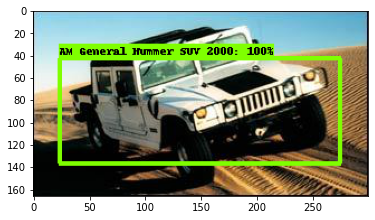

In [32]:
x = load_image_into_numpy_array(str(data_path / list(img_path)[0]))
plot_detections(x, boxes=np.array([[127/480, 50/640, 396/480, 587/640]]), 
                classes=[1], scores=[1], category_index=category_index, figsize=(12, 16))